In [1]:
!pip install torch
!pip install torchvision
!pip install plotly

In [3]:
import cv2
print("1")
import numpy as np
print("2")
from pipeline import Pipeline
print("3")
from f_1DVMD import Fastft,scale_data,smooth_signal
print("4")
import matplotlib.pyplot as plt
print("5")
from vmdpy import VMD  
print("6")
import h5py
print("7")

1
2
3
4
5
6
7


In [4]:
import os

# Main folder path
main_folder = '/Users/himanshubairwa/Desktop/MTP/cohface'

# First subfolder name
subfolder1_name = '1'

# Second subfolder name
subfolder2_name = '0'

# Construct the paths to the subfolders
subfolder1 = os.path.join(main_folder, subfolder1_name)
subfolder2 = os.path.join(subfolder1, subfolder2_name)

# List files in the second subfolder
files = os.listdir(subfolder2)

# Filter video and HDF5 files
video_files = [f for f in files if f.endswith('.mp4') or f.endswith('.avi')]
hdf5_files = [f for f in files if f.endswith('.hdf5')]

# Print the video and HDF5 files
print("Video files:")
for video_file in video_files:
    file_path = os.path.join(subfolder2, video_file)
    vid_path = file_path
    print(file_path)

print("\nHDF5 files:")
for hdf5_file in hdf5_files:
    file_path = os.path.join(subfolder2, hdf5_file)
    ref_path = file_path
    print(file_path)


Video files:
/Users/himanshubairwa/Desktop/MTP/cohface/1/0/data.avi

HDF5 files:
/Users/himanshubairwa/Desktop/MTP/cohface/1/0/data.hdf5


reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/1/0/data.avi
bpm_G:86


Text(0.5, 1.0, 'FFT of rPPG vs Frequency(Hz)')

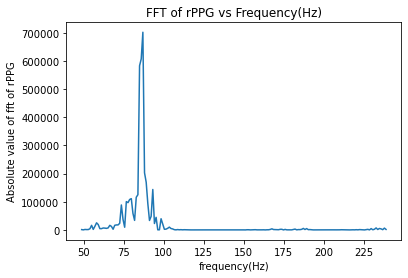

In [5]:
#signal reconstruction function
def reconst(modes,omega):
    index=np.where((omega>0.75)&(omega<4))
    rPPG=np.sum(modes[index],axis=0)
    return rPPG
    

pipe = Pipeline()

# vid_path = 'data.avi'
# ref_path = 'data.hdf5'

f=h5py.File(ref_path,'r')
ppg=np.asarray(f['pulse'])
ppg=ppg[256:15104]
ppg=scale_data(ppg,0,1)
freqs,fft,bpm,peak_value2=Fastft(ppg,256)
print(f'reference HR:{int(bpm)}')


raw_sig,skin_imgs,filt_sig = pipe.run_on_video(vid_path, roi_approach="holistic",method='cpu_SSR', roi_method="convexhull",pre_filt=True)

R=[]
G=[]
B=[]
l=len(skin_imgs)
for image in skin_imgs:
    R.append(np.mean(image[:,:,0]))
    G.append(np.mean(image[:,:,1]))
    B.append(np.mean(image[:,:,2]))
    try:
        cv2.imshow('img',image)
        cv2.waitKey(5)
    except Exception as e:
        print(e)

G=G[20:1180]

fps=20
Th=10
K=5
alpha= 8000   # moderate bandwidth constraint  (8000,7000)

u_G, u_hat_G, omega_G = VMD(G, 8000, 0, 10, 0, 1, 1e-7)
omega_G=omega_G[-1][:]*fps 


rPPG_G=reconst(u_G,omega_G)

rPPG_G=scale_data(rPPG_G,0,1)

rPPG_G=smooth_signal(rPPG_G, sample_rate = 20, window_length=17, polyorder=2)

freqs_of_interest,fft_of_interest,bpmG,peak_value2=Fastft(rPPG_G,20)

print(f'bpm_G:{int(bpmG)}')

plt.plot(freqs_of_interest,fft_of_interest)
plt.xlabel("frequency(Hz)")
plt.ylabel("Absolute value of fft of rPPG")
plt.title("FFT of rPPG vs Frequency(Hz)")

In [194]:
#feature 1
def column_wise_sum(matrix):
    rows = len(matrix)
    columns = len(matrix[0])
    sums = [0] * columns

    for j in range(columns):
        column_sum = 0
        for i in range(rows):
            column_sum += matrix[i][j]
        sums[j] = column_sum

    return sums


In [195]:
import numpy as np

def calculate_shannon_entropy(signal):
    # Count the occurrences of each unique amplitude in the signal
    unique_amplitudes, counts = np.unique(signal, return_counts=True)
    
    # Calculate the probability distribution of the signal amplitudes
    probabilities = counts / len(signal)
    
    # Compute the Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    # Convert the entropy value to an integer
#     entropy = int(entropy)
    
    return entropy


In [196]:
# feature 3: shannon log energy

def calculate_shannon_log_energy(signal):
    # Divide the signal into non-overlapping segments or bins
    segment_length = len(signal)  # Adjust this value based on your requirements
    
    # Calculate the energy for each segment
    energies = []
    for i in range(0, len(signal), segment_length):
        segment = signal[i:i+segment_length]
        energy = np.sum(np.square(segment))
        energies.append(energy)
    
    # Take the logarithm of the energy values
    log_energies = np.log(energies)
    
    # Convert the log energy values to integers
#     log_energies = log_energies.astype(int)
    
    return np.max(log_energies)



In [197]:
# feature 4: full power coorelation feature
import numpy as np
from scipy.linalg import toeplitz

def calculate_correlation_features(signal, Nfeat):
    # Step 1: Calculate unbiased auto-correlation
    N = len(signal)
    correlation = np.correlate(signal, signal, mode='full') / (N - np.abs(np.arange(-N+1, N)))

    # Step 2: Convert auto-correlation to Toeplitz matrix
    toeplitz_matrix = toeplitz(correlation[:N])
#     print(toeplitz_matrix)

    # Step 3: Calculate Pearson's correlation from Toeplitz matrix
    pearson_correlation = np.corrcoef(toeplitz_matrix, rowvar=False)

    # Step 4: Perform Eigen decomposition
    eigenvalues = np.linalg.eigvals(pearson_correlation)
#     print(len(eigenvalues))

    # Select top Nfeat eigenvalues as features
    features = eigenvalues[:Nfeat]

    return np.mean(np.array(features))

# # Example usage:
# signal = seg1
# Nfeat = 125
# # correlation_features = calculate_correlation_features(seg1, Nfeat)
# feat4_seg1 = calculate_correlation_features(seg1, Nfeat)

# print(len(feat4_seg1))
# plt.plot(feat4_seg1)


In [198]:
# feature 5: Power features

import numpy as np

def calculate_power_feature(signal, Nfeat, Lsp_ref):
    # Step 1: Calculate power spectral density (PSD)
    fft_result = np.fft.fft(signal)
    psd = np.abs(fft_result) ** 2

    # Step 2: Adjust PSD levels based on Lsp and Lsp_ref
    Lsp = int(np.log2(len(psd)))
    if Lsp >= Lsp_ref:
        power_feature = np.zeros(Nfeat)
        num_levels = min(Lsp, Nfeat)
        for i in range(num_levels):
            power_feature[i] = np.sum(psd[2 ** i: 2 ** (i + 1)])
    else:
        power_feature = np.zeros(Lsp_ref)
        for i in range(Lsp_ref):
            power_feature[i] = np.sum(psd[2 ** i: 2 ** (i + 1)])

    # Step 3: Normalize power feature to have unit norm
    power_feature /= np.linalg.norm(power_feature)

    return np.mean(np.array(power_feature))

# Example usage:
# signal = seg1
# Nfeat = 125
# Lsp_ref = 5
# # power_feature = calculate_power_feature(seg1, Nfeat, Lsp_ref)
# feat5_seg1 = calculate_power_feature(seg1, Nfeat, Lsp_ref)

# print(len(feat5_seg1))  # Output: 125
# print(feat5_seg1)
# plt.plot(feat5_seg1)


In [199]:
# Feature 6: Partial power coorelation

import numpy as np
from scipy.linalg import toeplitz

def calculate_partial_power_correlation_features(signal, Nfeat, Lsp_ref):
    # Step 1: Calculate unbiased auto-correlation
    N = len(signal)
    correlation = np.correlate(signal, signal, mode='full') / (N - np.abs(np.arange(-N+1, N)))

    # Step 2: Convert auto-correlation to Toeplitz matrix
    toeplitz_matrix = toeplitz(correlation[:N])

    # Step 3: Calculate Pearson's correlation from Toeplitz matrix
    pearson_correlation = np.corrcoef(toeplitz_matrix, rowvar=False)

    # Step 4: Perform Eigen decomposition
    eigenvalues = np.linalg.eigvals(pearson_correlation)

    # Step 5: Calculate partial power correlation feature
    Lsp = len(eigenvalues)
    if Lsp >= Lsp_ref:
        num_levels = min(Lsp, Nfeat)
        partial_power_feature = np.zeros(Nfeat)
        for i in range(num_levels):
            partial_power_feature[i] = np.sum(eigenvalues[:i+1])
    else:
        partial_power_feature = np.zeros(Lsp_ref)
        for i in range(Lsp_ref):
            partial_power_feature[i] = np.sum(eigenvalues[:i+1])

    return np.mean(np.array(partial_power_feature))

# # Example usage:
# signal = seg1
# Nfeat = 125
# Lsp_ref = 5
# # partial_power_feature = calculate_partial_power_correlation_features(seg1, Nfeat, Lsp_ref)
# feat6_seg1 = calculate_partial_power_correlation_features(seg1, Nfeat, Lsp_ref)

# print(len(feat6_seg1))  # Output: 125
# print(feat6_seg1)
# plt.plot(feat6_seg1)

# Driving Function

reference HR:60

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/32/0/data.avi
bpm_G:60
reference HR:63

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/32/1/data.avi
bpm_G:62
reference HR:63

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/32/3/data.avi
bpm_G:54
reference HR:64

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/32/2/data.avi
bpm_G:57
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/35/0/data.avi
bpm_G:76
reference HR:83

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/35/1/data.avi
bpm_G:99
reference HR:82

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/35/3/data.avi
bpm_G:61
reference HR:87

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/35/2/data.avi
bpm_G:147
reference HR:56

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/34/0/data.avi
bpm_G:56
reference HR:61

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/34/1/data.avi
bpm_G:61

<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:65

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/7/3/data.avi
bpm_G:60


<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:62

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/7/2/data.avi
bpm_G:189
reference HR:52

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/29/0/data.avi
bpm_G:52
reference HR:52

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/29/1/data.avi
bpm_G:52


<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:56

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/29/3/data.avi
bpm_G:53
reference HR:53

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/29/2/data.avi
bpm_G:53
reference HR:56

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/16/0/data.avi
bpm_G:54
reference HR:56

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/16/1/data.avi
bpm_G:56
reference HR:57

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/16/3/data.avi
bpm_G:57
reference HR:56

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/16/2/data.avi
bpm_G:228
reference HR:61

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/0/data.avi
bpm_G:145
reference HR:67

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/7/data.avi
bpm_G:52


<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:68

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/6/data.avi
bpm_G:106
reference HR:61

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/1/data.avi
bpm_G:62
reference HR:71

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/4/data.avi
bpm_G:71
reference HR:64

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/3/data.avi
bpm_G:64
reference HR:63

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/2/data.avi
bpm_G:86
reference HR:68

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/6/5/data.avi
bpm_G:68


<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:65

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/28/0/data.avi
bpm_G:63
reference HR:65

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/28/1/data.avi
bpm_G:64
reference HR:66

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/28/3/data.avi
bpm_G:60
reference HR:67

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/28/2/data.avi
bpm_G:67
reference HR:57

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/17/0/data.avi
bpm_G:53
reference HR:58

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/17/1/data.avi
bpm_G:58
reference HR:61

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/17/3/data.avi
bpm_G:61
reference HR:60

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/17/2/data.avi
bpm_G:60
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/1/0/data.avi
bpm_G:86
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/1/1/data.avi
bpm_G:84
re

<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:69

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/19/1/data.avi
bpm_G:69
reference HR:68

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/19/3/data.avi
bpm_G:68
reference HR:70

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/19/2/data.avi
bpm_G:70
reference HR:70

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/8/0/data.avi
bpm_G:70
reference HR:75

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/8/1/data.avi
bpm_G:55
reference HR:69

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/8/3/data.avi
bpm_G:52
reference HR:69

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/8/2/data.avi
bpm_G:84
reference HR:85

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/21/0/data.avi
bpm_G:48
reference HR:83

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/21/1/data.avi
bpm_G:84
reference HR:87

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/21/3/data.avi
bpm_G:91
refe

<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:49

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/31/0/data.avi
bpm_G:49
reference HR:50

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/31/1/data.avi
bpm_G:64
reference HR:51

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/31/3/data.avi
bpm_G:141
reference HR:49

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/31/2/data.avi
bpm_G:49
reference HR:55

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/30/0/data.avi
bpm_G:103
reference HR:60

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/30/1/data.avi
bpm_G:60
reference HR:63

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/30/3/data.avi
bpm_G:63
reference HR:51

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/30/2/data.avi
bpm_G:173
reference HR:65

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/37/0/data.avi
bpm_G:53
reference HR:55

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/37/1/data.avi
bpm_G:

<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:53

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/4/2/data.avi
bpm_G:100
reference HR:83

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/15/0/data.avi
bpm_G:93
reference HR:83

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/15/1/data.avi
bpm_G:142
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/15/3/data.avi
bpm_G:82
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/15/2/data.avi
bpm_G:58
reference HR:68

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/3/0/data.avi
bpm_G:160
reference HR:70

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/3/1/data.avi
bpm_G:55
reference HR:72

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/3/3/data.avi
bpm_G:72
reference HR:71

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/3/2/data.avi
bpm_G:70
reference HR:54

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/12/0/data.avi
bpm_G:54
re

<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:66

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/13/0/data.avi
bpm_G:66
reference HR:66

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/13/1/data.avi
bpm_G:48


<ipython-input-199-6d477a0d4079>:26: ComplexWarning: Casting complex values to real discards the imaginary part
  partial_power_feature[i] = np.sum(eigenvalues[:i+1])


reference HR:67

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/13/3/data.avi
bpm_G:67
reference HR:68

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/13/2/data.avi
bpm_G:67
reference HR:72

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/5/0/data.avi
bpm_G:65
reference HR:72

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/5/1/data.avi
bpm_G:100
reference HR:75

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/5/3/data.avi
bpm_G:58
reference HR:73

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/5/2/data.avi
bpm_G:58
reference HR:82

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/14/0/data.avi
bpm_G:55
reference HR:84

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/14/1/data.avi
bpm_G:81
reference HR:83

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/14/3/data.avi
bpm_G:61
reference HR:82

Processing Video: /Users/himanshubairwa/Desktop/MTP/cohface/14/2/data.avi
bpm_G:82
ref

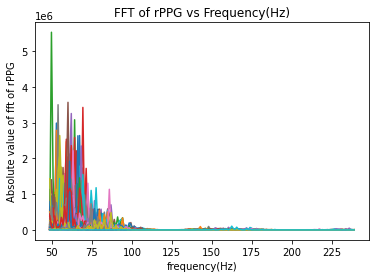

In [200]:
import os
import pandas as pd
import numpy as np

# Create an empty DataFrame
df = pd.DataFrame(columns=['Video', 'Segment', 'Feature1', 'Feature2', 'Feature3', 'Feature4', 'Feature5', 'Feature6', 'GroundTruth'])

# Main folder path
main_folder_path = '/Users/himanshubairwa/Desktop/MTP/cohface'

# Iterate over main folder
for folder_name in os.listdir(main_folder_path):
    folder_path = os.path.join(main_folder_path, folder_name)
    
    # Check if it is a subfolder
    if os.path.isdir(folder_path):
        
        # Iterate over subfolder
        for subfolder_name in os.listdir(folder_path):
            subfolder_path = os.path.join(folder_path, subfolder_name)
            
            # Check if it is a folder containing .avi and .hdf5 files
            if os.path.isdir(subfolder_path):
                
                # Get the .avi and .hdf5 file paths
                avi_file_path = os.path.join(subfolder_path, 'data.avi')
                hdf5_file_path = os.path.join(subfolder_path, 'data.hdf5')
                
                # Perform processing on the files
                def reconst(modes,omega):
                    index=np.where((omega>0.75)&(omega<4))
                    rPPG=np.sum(modes[index],axis=0)
                    return rPPG


                pipe = Pipeline()

                vid_path = avi_file_path
                ref_path = hdf5_file_path

                f=h5py.File(ref_path,'r')
                ppg=np.asarray(f['pulse'])
                ppg=ppg[256:15104]
                ppg=scale_data(ppg,0,1)
                freqs,fft,bpm,peak_value2=Fastft(ppg,256)
                print(f'reference HR:{int(bpm)}')


                raw_sig,skin_imgs,filt_sig = pipe.run_on_video(vid_path, roi_approach="holistic",method='cpu_SSR', roi_method="convexhull",pre_filt=True)

                R=[]
                G=[]
                B=[]
                l=len(skin_imgs)
                for image in skin_imgs:
                    R.append(np.mean(image[:,:,0]))
                    G.append(np.mean(image[:,:,1]))
                    B.append(np.mean(image[:,:,2]))
                    try:
                        cv2.imshow('img',image)
                        cv2.waitKey(5)
                    except Exception as e:
                        print(e)

                G=G[20:1180]

                fps=20
                Th=10
                K=5
                alpha= 8000   # moderate bandwidth constraint  (8000,7000)

                u_G, u_hat_G, omega_G = VMD(G, 8000, 0, 10, 0, 1, 1e-7)
                omega_G=omega_G[-1][:]*fps 


                rPPG_G=reconst(u_G,omega_G)

                rPPG_G=scale_data(rPPG_G,0,1)

                rPPG_G=smooth_signal(rPPG_G, sample_rate = 20, window_length=17, polyorder=2)

                freqs_of_interest,fft_of_interest,bpmG,peak_value2=Fastft(rPPG_G,20)

                print(f'bpm_G:{int(bpmG)}')

                plt.plot(freqs_of_interest,fft_of_interest)
                plt.xlabel("frequency(Hz)")
                plt.ylabel("Absolute value of fft of rPPG")
                plt.title("FFT of rPPG vs Frequency(Hz)")
                
                # Your processing code goes here
                def scale_data(data, lower= 0, upper = 1024):
                    rng = np.max(data)-np.min(data)
                    minimum = np.min(data)
                    data = (upper - lower) * ((data-minimum)/rng) + lower
                    return data

                def interpolation(trace,t,fs,fps):
                    trace = np.array(trace)
                    old_t = np.linspace(0,t,t*fps) 
                    new_t = np.linspace(0,t,t*fs) 
                    return scale_data(np.interp(new_t,old_t,trace), lower= 0, upper = 1)

                PL = 8 # segment of 8 sec
                fs = 125# sampling rate of signal
                window_len = PL*fs #length of each segment is 1000
                rPPG_interpolated= interpolation(rPPG_G[0:1120],56,125,20)

                seg=[]
                for i in range(0,len(rPPG_interpolated),window_len):
                    seg.append(rPPG_interpolated[i:i+window_len])

                for segment_num, segment in enumerate(seg, start=1):
                    # Calculate features based on the processed data
                    seg_mat = np.reshape(segment,(8,125))
                    feature1 = np.mean(np.array(column_wise_sum(seg_mat)))
                    feature2 = np.max(calculate_shannon_entropy(segment))
                    feature3 = calculate_shannon_log_energy(segment)
                    feature4 = np.abs(calculate_correlation_features(segment,125))
                    feature5 = calculate_power_feature(segment,125,5)
                    feature6 = calculate_partial_power_correlation_features(segment,125,5)

                    freqs_of_interest,fft_of_interest,bpmGG,peak_value2=Fastft(segment,20)
                    ground_truth = int(bpm)
                    
                    # Get video number from the folder name
                    video_num = folder_name
                    
                    # Add row to the DataFrame
                    df = df.append({'Video': video_num, 'Segment': segment_num,
                                    'Feature1': feature1, 'Feature2': feature2,
                                    'Feature3': feature3, 'Feature4': feature4,
                                    'Feature5': feature5, 'Feature6': feature6,
                                    'GroundTruth': ground_truth},
                                   ignore_index=True)

# Display the DataFrame
print(df)


In [201]:
df

,Video,Segment,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,GroundTruth
0,32,1,4.082212,9.965784,5.743223,7.999596,0.010827,965.783206,60
1,32,2,4.139532,9.965784,5.677653,7.999810,0.011140,969.367956,60
2,32,3,4.093475,9.965784,5.681894,7.999731,0.011632,968.900052,60
3,32,4,4.023281,9.965784,5.626228,7.999714,0.010793,979.528521,60
4,32,5,4.120231,9.965784,5.753075,7.999974,0.010179,974.810302,60
...,...,...,...,...,...,...,...,...,...
1115,25,3,3.878105,9.965784,5.538882,7.994611,0.008113,935.193424,87
1116,25,4,3.883999,9.965784,5.490877,7.995746,0.008216,915.695450,87
1117,25,5,3.890270,9.965784,5.492227,7.996179,0.008350,886.605952,87
1118,25,6,3.895458,9.965784,5.507714,7.990051,0.008396,899.795181,87


In [202]:
df.to_csv("test1.csv")


In [1]:
#File saves as test1.csv where all the features are included